In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

from mirna import Classifier
from mirna import Featuring
from mirna import InteractionModel
from mirna import PairedDataset
from mirna import collate_paired_sequences
from mirna import plot_losses

In [2]:
data_dir = "mirna-data"
train_file = os.path.join(data_dir, "miRAW/train_seed_1234_40.txt")
val_file = os.path.join(data_dir, "miRAW/valid_seed_1234_20.txt")
epochs = 10

# from google.colab import drive
#
# drive.mount('/content/drive')
# data_dir = "drive/MyDrive/ppi-data"
# train_file = os.path.join(data_dir, spe, "action/train_action.tsv")
# val_file = os.path.join(data_dir, spe, "action/test_action.tsv")
# epochs = 50

# Featuring
embed_dim = 128
feature_heads = 4
feature_layers = 1
d_model = 32
feature_dim = 64
feature_layers = 6

# InteractionModel
action_heads = 2
action_layers = 3

# Train
batch_size = 32
lr = 0.001

seed = 1234
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

train_df = pd.read_csv(train_file, sep="\t", header=None)
train_dataset = PairedDataset(train_df[0].to_list(), train_df[1].to_list(), train_df[2].to_list())
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_paired_sequences,
    shuffle=True,
)

val_df = pd.read_csv(val_file, sep="\t", header=None)
val_dataset = PairedDataset(val_df[0].to_list(), val_df[1].to_list(), val_df[2].to_list())
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_paired_sequences
)


In [3]:
featuring = Featuring(embed_dim, d_model, feature_dim, feature_heads, feature_layers)
classifier = Classifier(feature_dim)

model = InteractionModel(featuring, classifier, action_heads, action_layers)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

In [4]:
losses = []
val_losses = []

for epoch in range(epochs):
    batch_losses = []
    for x1, x2, y in train_loader:
        model.train()
        x1 = x1.to(device)
        x2 = x2.to(device)
        y = y.to(device)

        y_pred = model(x1, x2)
        batch_loss = F.binary_cross_entropy(y_pred, y)
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_losses.append(batch_loss.item())

    loss = np.mean(batch_losses)
    losses.append(loss)

    model.eval()
    with torch.no_grad():
        batch_losses = []
        n = 0
        accuracy_average = 0
        for x1, x2, y in val_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            y = y.to(device)
            y_pred = model(x1, x2)
            batch_loss = F.binary_cross_entropy(y_pred, y)
            batch_losses.append(batch_loss.item())
            accuracy = accuracy_score(y.cpu(), (y_pred.cpu() > 0.5).int())
            accuracy_average = (accuracy_average * n + accuracy * x1.shape[0]) / (n + x1.shape[0])
            n = n + x1.shape[0]

        val_loss = np.mean(batch_losses)
        val_losses.append(val_loss)

    print(f"Epoch: {epoch + 1} -- loss: {loss:.4f}, val_loss: {val_loss:.4f}, accuracy: {accuracy_average:.4f}")

Epoch: 1 -- loss: 0.6594, val_loss: 0.6928, accuracy: 0.5000
Epoch: 2 -- loss: 0.7093, val_loss: 0.6921, accuracy: 0.5000
Epoch: 3 -- loss: 0.8346, val_loss: 0.6914, accuracy: 0.5000
Epoch: 4 -- loss: 0.6619, val_loss: 0.6898, accuracy: 0.5000
Epoch: 5 -- loss: 0.6616, val_loss: 0.6876, accuracy: 0.5000
Epoch: 6 -- loss: 0.5472, val_loss: 0.6842, accuracy: 0.6500
Epoch: 7 -- loss: 0.6340, val_loss: 0.6816, accuracy: 0.5500
Epoch: 8 -- loss: 0.5842, val_loss: 0.6777, accuracy: 0.6500
Epoch: 9 -- loss: 0.6365, val_loss: 0.6751, accuracy: 0.6500
Epoch: 10 -- loss: 0.5933, val_loss: 0.6719, accuracy: 0.6000


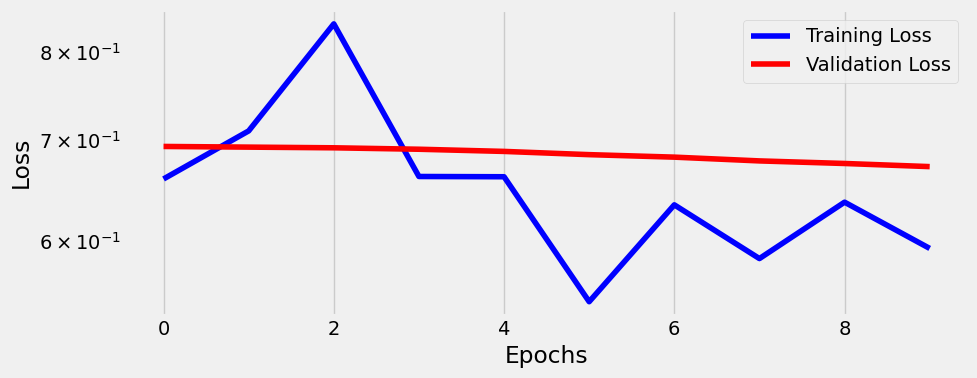

In [5]:
fig = plot_losses(losses, val_losses)